# AOS AuxTel: update out-of-focus  WCS exposures using astrometric fitting of the in-focus exposure

Summary: 

   * the initial WCS in inspected auxTel images was off by ~180 degrees. Even after accounting for that it was ~100px off. 
   * we use a triad of images: in-focus, extra-focal, and intra-focal
   * we run `SourceDetectionTask` to detect position of sources  on the in-focus exposure
   * we  load reference catalog objects from the location given by ra,dec, rotation angle  with `ts_wep` `RefCatalogInterface`
   * we cross-match the detected sources catalog against reference catalog to correct the WCS  with `AstrometryTask`
   * we update the out-of-focus exposures with new WCS 
   * we run `ts_wep` `EstimateZernikesLatissTask` to estimate Zernikes based on the intra-focal and extra-focal images
   * we plot the resulting Zernike estimates and donut cutout stamps. All results are saved as a numpy pickle.
    

Technical details:
 * run on `lsst-devl02` with `w_2021_43` of the `lsst_distrib`
 * using `ts_wep` on `tickets/DM-31655` branch, rebased against `develop` 
 * last verified to run: `2021-10-25` 
 

1) Read in the extra, intra, and in-focus exposures:

In [2]:
from lsst.daf import butler as dafButler
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')


exposure_intra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800487},
                      collections=['u/scichris/Latiss/postISRtest'])


exposure_extra = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800488},
                      collections=['u/scichris/Latiss/postISRtest'])

postIsr = butler.get('postISRCCD', dataId={'instrument':'LATISS', 'detector':0, 
                                     'exposure':2021090800489
                                        },
                      collections=['u/scichris/Latiss/postISRtest'])

2) Use the in-focus image to do source detection, and  do astrometry matching against  a reference catalog to obtain an updated WCS

In [47]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

#Set up the task, it requires a config when we instantiate it
charConfig = CharacterizeImageConfig()
charConfig.requireCrForPsf= False

charImageTask = CharacterizeImageTask(None, config=charConfig)
charImageTask.installSimplePsf.fwhm=2

#run the task on our exposure and save the output. This takes a minute to run 
charResult = charImageTask.run(postIsr)

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()
Skipping cosmic ray detection: Too many CR pixels (max 10000)
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default 

InvalidParameterError: 
  File "src/PsfexPsf.cc", line 233, in virtual std::shared_ptr<lsst::afw::image::Image<double> > lsst::meas::extensions::psfex::PsfexPsf::_doComputeImage(const Point2D&, const lsst::afw::image::Color&, const Point2D&) const
    Only spatial variation (ndim == 2) is supported; saw 0 {0}
lsst::pex::exceptions::InvalidParameterError: 'Only spatial variation (ndim == 2) is supported; saw 0'


Since that fails, try defining PSF manually:

Define the PSF to fit:

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay


def gkern(l=3, sig=0.5):
    """
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)
#Run detection and measure on the correlated image using the simple PSF
#NOTE should look at which centroid is run to see if there are better ones
psf_array = gkern(l=11, sig=2.5)
# #psf_array = gkern(l=5, sig=0.5)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

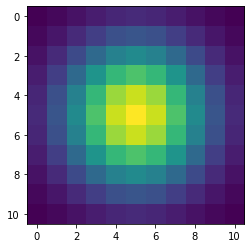

In [49]:
plt.imshow(psf_image.array)

Run source detection:

In [50]:
#Use DM tasks to run: detection, measure using the simple PSF (no deblending)
#From Merlin: It's usually a good idea to construct all Tasks before using any of them, mostly
# to define the full schema of any catalogs we'll produce up front.

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue = 5 #30  # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"#"stdev"   # units for thresholdValue
#configDetection.minPixels = 200 # 1000#
configDetection.minPixels = 200
#configDetection.charImage.background.weighting = False  
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image 
from copy import deepcopy
exposure = deepcopy(postIsr)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure,)# weighing=False)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/meas_algorithms/22.0.1-25-gbfca4b99+4d440cff96/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


Plot the source catalog:

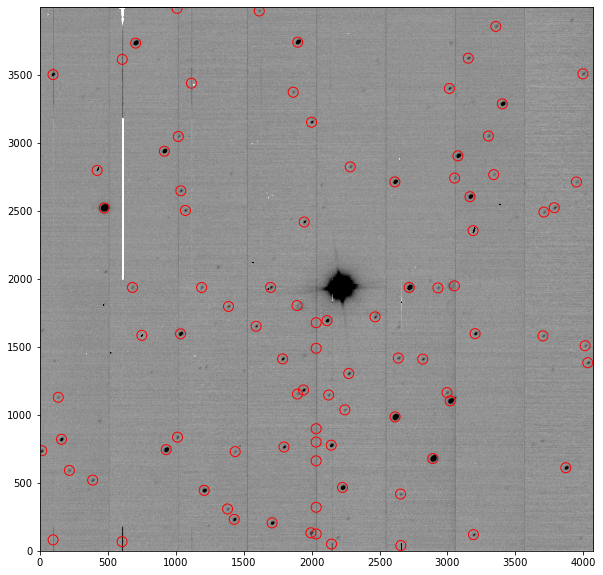

In [52]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()
data = exposure.getImage().getArray()
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(data)
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
ax.scatter(catalog['slot_Centroid_x'], catalog['slot_Centroid_y'],s=100,facecolors='none', edgecolors='red',)

Ok, looks good! 

Use the new `RefCatalogInterface` from `ts_wep` to load the reference catalog for astrometry matching:

In [53]:
# need to provide ra,dec, rotation angle of the exposure 
visitInfo = postIsr.getInfo().getVisitInfo()

boresightRa = visitInfo.getBoresightRaDec().getRa().asDegrees()
boresightDec = visitInfo.getBoresightRaDec().getDec().asDegrees()
boresightRotAng = visitInfo.getBoresightRotAngle().asDegrees()

In [54]:
from lsst.ts.wep.task.RefCatalogInterface import RefCatalogInterface

refCatInterface = RefCatalogInterface(boresightRa, boresightDec,boresightRotAng)

shardIds = refCatInterface.getShardIds()

from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/', instrument='LATISS')
catalogName = 'gaia_dr2_20200414'
collections = 'refcats'

dataRefs, dataIds = refCatInterface.getDataRefs(shardIds, butler, catalogName, collections)

from lsst.ts.wep.task.GenerateDonutCatalogWcsTask import (GenerateDonutCatalogWcsTask, 
                                                             GenerateDonutCatalogWcsTaskConfig)

donutCatConfig = GenerateDonutCatalogWcsTaskConfig()
donutCatConfig.filterName= 'phot_g_mean'

# instantiate the task with the appropriate config 
donutCatTask = GenerateDonutCatalogWcsTask(config=donutCatConfig)

refObjLoader = donutCatTask.getRefObjLoader(dataRefs)
refObjLoader.config.filterMap = {"g": "phot_g_mean" }

/project/scichris/aos/ts_wep/python/lsst/ts/wep/task/DonutSourceSelectorTask.py:84: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def selectSources(self, sourceCat, matches=None, exposure=None):


Show the original and rotated WCS. Pass the postISR with rotated WCS to the astrometric matching 

In [56]:
#camera = "LATISS"
originalDonutCatStruct = donutCatTask.run(dataRefs, postIsr, )

root INFO: Loading reference objects from region bounded by [305.36434487, 308.82298656], [-87.54875820, -87.39704029] RA Dec
root INFO: Loaded 181 reference objects


In [57]:
import lsst.geom
from lsst.afw.geom import makeSkyWcs,  makeCdMatrix


wcs = postIsr.getWcs()
rotationInDeg = 180 

info = postIsr.getInfo().getVisitInfo()
orientation = (info.getBoresightRotAngle().asDegrees()+\
               rotationInDeg)* lsst.geom.degrees#  info.getBoresightRotAngle()# 0 * lsst.geom.degrees  # 
flipX = True
scale =  wcs.getPixelScale() # 0.2 * lsst.geom.arcseconds  # how many arcsec per pixel 
cdMatrix = makeCdMatrix(scale=scale, orientation=orientation, flipX=flipX)

pxOrigin = wcs.getPixelOrigin()

crpix = pxOrigin
crval = wcs.getSkyOrigin() # lsst.geom.SpherePoint(0.0*lsst.geom.degrees, 0.0*lsst.geom.degrees)
newWcs = makeSkyWcs(crpix=crpix, crval=crval, cdMatrix=cdMatrix)

postIsr.setWcs(newWcs)

rotatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )

root INFO: Loading reference objects from region bounded by [305.30492316, 308.76327582], [-87.54778646, -87.39601829] RA Dec
root INFO: Loaded 178 reference objects


In [58]:
import astropy.units as u

originalCatalog  = originalDonutCatStruct.donutCatalog
rotatedCatalog = rotatedDonutCatStruct.donutCatalog

mag_list = (originalCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

originalCatalog['mags'] = mag_array
mask = mag_array<16
originalCatalogMagCut = originalCatalog[mask]


mag_list = (rotatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

rotatedCatalog['mags'] = mag_array
mask = mag_array<16
rotatedCatalogMagCut = rotatedCatalog[mask]

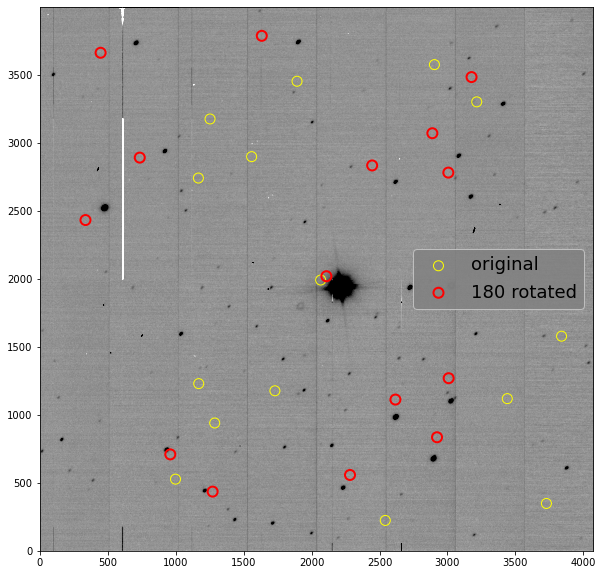

In [70]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
for cat,color,lw,label in zip([originalCatalogMagCut, rotatedCatalogMagCut], 
                    ['yellow', 'red'],
                       [1,2],
                       ['original', '180 rotated']):

    ax.scatter(cat['centroid_x'], 
           cat['centroid_y'], 
           s=100, 
           facecolors='none', edgecolors=color, lw=lw, 
           label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

I pass the postISR with WCS rotated by 180 degrees to the astrometry fitting

Do the astrometry fitting:

In [71]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask
import lsst.afw.display as afwDisplay



astromConfig = AstrometryTask.ConfigClass()
# Pick your retarget here if necessary
# astromConfig.wcsFitter.retarget(FitAffineWcsTask)
# astromConfig.wcsFitter.retarget(FitTanSipWcsTask)
# astromConfig.referenceSelector.doMagLimit = False
#    You probably *do* want to do a mag limit, because your donuts are
#    unlikely to go as deep as GAIA, and if you have too much choice the matcher
#    will always succeed, but finding false matches with huge scatter.
magLimit = MagnitudeLimit()
magLimit.minimum = 10
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.99
astromConfig.matcher.maxOffsetPix = 100
astromConfig.wcsFitter.order = 2
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15


Need to redefine filter label

In [73]:
# this is a bit sleezy (as RHL would say) but I'm just forcing the exposure
# to have the same name as the one in the Gaia catalog for now

# this method of making a filter doesn't work anymore ...
# "defineFilter" is deprecated ... 
# referenceFilterName = 'phot_g_mean'
# defineFilter(referenceFilterName, 656.28)
# referenceFilter = afwImage.Filter(referenceFilterName)
# exposure.setFilter(referenceFilter)

# the shift is described  here 
# https://community.lsst.org/t/afw-image-filter-is-now-deprecated/4675 
from lsst.afw.image import FilterLabel
postIsr.setFilterLabel(FilterLabel('phot_g_mean'))

In [74]:

schema = lsst.afw.table.SourceTable.makeMinimalSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=postIsr,)

root INFO: Loading reference objects from region bounded by [305.30492316, 308.76327582], [-87.54778646, -87.39601829] RA Dec
root INFO: Loaded 178 reference objects
root INFO: Correcting reference catalog for proper motion to <Time object: scale='tai' format='mjd' value=59466.24454000155>


Now this updated the WCS in the exposure. Use the updated WCS to plot sources again:

In [75]:
updatedDonutCatStruct =  donutCatTask.run(dataRefs, postIsr, )

root INFO: Loading reference objects from region bounded by [305.32830253, 308.66755265], [-87.54229926, -87.39590876] RA Dec
root INFO: Loaded 173 reference objects


In [76]:
updatedCatalog  = updatedDonutCatStruct.donutCatalog

mag_list = (updatedCatalog['source_flux'].values * u.nJy).to(u.ABmag)
mag_array = np.array(mag_list)

updatedCatalog['mags'] = mag_array
mask = mag_array<16
updatedCatalogMagCut = updatedCatalog[mask]


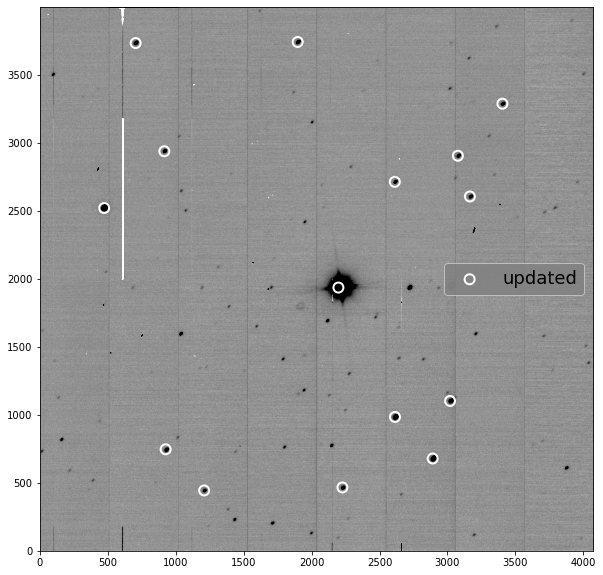

In [77]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()

fig,ax = plt.subplots(1,1,figsize=(10,10))
data = postIsr.image.array
vmin,vmax = zscale.get_limits(data)
ax.imshow(data, vmin=vmin, vmax=vmax,cmap='Greys', origin='lower')
cat = updatedCatalogMagCut
color = 'white'
lw=2
label='updated'

ax.scatter(cat['centroid_x'], 
       cat['centroid_y'], 
       s=100, 
       facecolors='none', 
        edgecolors=color, lw=lw, 
       label=label)
ax.legend(fontsize=18, loc='center right', facecolor='grey')

As we see, good fit! So the astrometry worked correctly to update the WCS. 

Update the WCS in the defocal exposures to that of the in-focus exposure:

In [78]:
focalWcs = postIsr.getWcs()

exposure_intra.setWcs(focalWcs)
exposure_extra.setWcs(focalWcs)

In [80]:
exp_pair = [exposure_intra, exposure_extra]

Run Zernike estimation using the magnitude-cut donut catalog:

In [81]:
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'
# This will take around a minute on medium instance on RSP
zernikeOutput = estimateZernikeTask.run(exp_pair, updatedCatalogMagCut,"LATISS")

In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
0 / 15
imageCoCenter: (x, y) = (   99.32,  101.49)

imageCoCenter: (x, y) = (   99.84,   99.38)

itr = 0, z4-z22
[ -1.  64. -85.  22.  35. -20.  -7. -17.  16.  -0.  -6.  -7.  -7.  -5.
  -1.   1.   3.   2.   6.]
itr = 1, z4-z22
[ -2.  65. -85.  23.  34. -21.  -8. -17.  16.  -0.  -6.  -7.  -6.  -5.
  -0.   1.   3.   2.   6.]
itr = 2, z4-z22
[ -2.  66. -87.  20.  33. -20.  -9. -17.  16.  -1.  -5.  -7.  -6.  -3.
  -0.   1.   3.   2.   6.]
itr = 3, z4-z22
[  -3.   91. -117.   21.   32.  -20.   -9.  -17.   15.   -0.   -5.   -7.
   -5.   -4.   -0.    1.    3.    2.    6.]
itr = 4, z4-z22
[  -3.  108. -138.   22.   33.  -21.   -8.  -17.   14.    0.   -6.   -6.
   -6.   -5.   -0.    1.    2.    2.    6.]
itr = 5, z4-z22
[ -18.  127. -123.    8.   11.  -27.  -12.  -22.   14.   -0.   -5.   -6.
    2.    0.   -0.    0.    3.    2.    7.]
itr 

itr = 6, z4-z22
[  7.  29. -55.  -0.  17. -30.  -6.  -8.   4.   0.   0.  -2.  -2.  -0.
  -0.   3.   2.  -1.   2.]
itr = 7, z4-z22
[  0.  35. -55.  -3.   7. -36.  -7.  -9.   4.   0.   0.  -2.   1.   1.
  -0.   2.   2.  -1.   2.]
itr = 8, z4-z22
[ -7.  40. -54.  -1.  13. -43.  -8. -10.   4.  -0.   0.  -1.  -1.   0.
  -0.   2.   2.  -1.   2.]
itr = 9, z4-z22
[ -5.  43. -54.  -3.  13. -41. -10. -11.   4.   0.   0.  -2.  -1.   1.
  -0.   2.   3.  -2.   2.]
itr = 10, z4-z22
[ -3.  47. -54.  -3.  13. -40. -11. -11.   4.   0.   0.  -3.  -1.   1.
  -0.   2.   4.  -3.   3.]
itr = 11, z4-z22
[ -0.  51. -54.  -1.  15. -39. -12. -12.   4.  -0.   1.  -3.  -2.   0.
  -0.   2.   4.  -3.   3.]
itr = 12, z4-z22
[  2.  54. -54.  -4.  13. -38. -14. -12.   4.   0.   1.  -4.  -1.   1.
  -0.   2.   5.  -4.   3.]
itr = 13, z4-z22
[  3.  57. -53.  -2.  13. -38. -15. -13.   4.   0.   1.  -5.  -1.   0.
  -0.   2.   6.  -5.   3.]
itr = 14, z4-z22
[  5.  60. -53.  -4.  12. -37. -16. -13.   4.   0.   1.  -5.  -1.  

itr = 0, z4-z22
[  7.  18. -17.   3.   4.  -3.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   0.]
itr = 1, z4-z22
[ 11.  16. -17.   2.   3.  -3.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   0.]
itr = 2, z4-z22
[ 15.  17. -18.   3.   4.  -3.   4.  -3.   3.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 3, z4-z22
[ 19.  26. -28.   2.   3.  -2.   4.  -3.   2.  -1.  -1.  -1.  -1.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 4, z4-z22
[ 23.  36. -38.   3.   4.  -2.   4.  -3.   2.  -1.  -1.  -1.  -1.  -1.
  -1.   0.  -0.  -0.   1.]
itr = 5, z4-z22
[ 23.  43. -38.  -0.  -1.  -4.   6.  -4.   2.  -1.  -1.  -1.   1.   0.
  -1.   0.  -0.  -0.   1.]
itr = 6, z4-z22
[ 20.  50. -38.   2.   2.  -5.   8.  -5.   2.  -1.  -1.  -1.  -0.  -0.
  -1.   0.  -0.  -0.   1.]
itr = 7, z4-z22
[ 17.  56. -39.  -0.  -0.  -6.  10.  -6.   2.  -1.  -1.  -1.   1.   0.
  -1.  -0.  -0.  -0.   1.]
itr = 8, z4-z22
[ 12.  62. -39.   3.   3.  -7.  12.  -7.   2.  -0.  -1.  -1.  -0.  -1.
 

itr = 9, z4-z22
[  8.  51. -21.   1.   1.   3.  -2.  -7.   1.  -0.  -3.  -3.   1.  -0.
   0.  -1.   1.  -1.   1.]
itr = 10, z4-z22
[  9.  55. -21.   1.  -1.   1.  -3.  -7.   1.  -0.  -4.  -4.   1.  -0.
   0.  -1.   1.  -1.   1.]
itr = 11, z4-z22
[ 10.  59. -22.   1.  -1.  -1.  -3.  -8.   1.  -0.  -4.  -5.   1.  -0.
   0.  -1.   1.  -1.   2.]
itr = 12, z4-z22
[ 11.  64. -22.   1.  -1.  -3.  -3.  -8.   1.  -0.  -5.  -7.   2.  -0.
   0.  -1.   2.  -1.   2.]
itr = 13, z4-z22
[ 13.  68. -22.   2.  -2.  -4.  -3.  -8.   1.  -0.  -6.  -8.   2.  -0.
  -0.  -1.   2.  -1.   2.]
itr = 14, z4-z22
[ 13.  72. -22.   3.  -0.  -6.  -3.  -8.   1.  -0.  -7.  -9.   1.  -1.
  -0.  -1.   2.  -2.   2.]
14 / 15
imageCoCenter: (x, y) = (   98.66,   99.74)

imageCoCenter: (x, y) = (  100.00,   99.46)

itr = 0, z4-z22
[-2. 12. -2. -7.  5. -4. -1. -1.  0. -1. -1. -1. -1.  1.  0. -0. -1. -1.
  1.]
itr = 1, z4-z22
[-4. 12. -1. -7.  5. -3. -1. -1.  0. -1. -1. -1. -1.  2. -0. -0. -1. -1.
  1.]
itr = 2, z4-z22
[-5. 12

Store the results:

In [82]:
# store zernikes as dict
zernikes = zernikeOutput.getDict()
np.save(f'zerDic_auxTel_2021090800487-9.npy',zernikes)

Plot the fit results with donut image:

In [122]:
# plot the truth vs simulation... 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from copy import copy
from lsst.ts.wep.DonutDetector import DonutDetector
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

def plot_results_and_image(data=postIsr.image.array, title = 'auxTel,2021090800487-9', 
                 fname = 'auxTel_wcs_updated_2021090800487.png',
                zkResultsFile ='zerDic_auxTel_2021090800487-9.npy',
                           showZkByName = False
                ):
   

    # read the fit results 
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()
    
    # plot the figure ...   
    fig = plt.figure(figsize=(14, 5))
     
    ####################################
    ### left - plot the fit results  ###
    #################################### 
        
    #add_axes([xmin,ymin,dx,dy]) 
    ax1 = fig.add_axes([0,0,0.6,1])  

    for i in range(len(zkFit['outputZernikesRaw'])):
        if i == 8:
            continue
        ax1.plot(np.arange(4, 23),zkFit['outputZernikesRaw'][i], 
                 '-d', label=f'donut {i}')
        ax1.set_xlabel('Zernike Number', size=14)
        ax1.set_ylabel('Avg Zernike Coefficient (microns)', size=14)
        
    
    ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[1., 0.5])
    ax1.set_title(title, fontsize=18)
    ax1.set_xticks(np.arange(4,23)[::2])
    ax1.grid()
    
    if showZkByName:
        ax1.set_xticks(np.arange(4,23))
        ax1.set_xticklabels(['z4: Defocus', 'z5: Vertical Astigmatism', 
                            'z6: Vertical Trefoil', 'z7: Vertical Coma',
                           'z8: Horizontal Coma', 'z9: Obliue Trefoil',
                           'z10: Oblique Quadrafoil', 'z11: Oblique Secondary Astigmatism',
                           'z12: Primary Spherical', 'z13: Vertical Secondary Astigmatism',
                           'z14: Vertical Quadrafoil', 
                           'z15: Vertical Pentafoil', 'z16: Vertical Secondary Trefoil', 
                           'z17: Vertical Secondary Coma',
                           'z18: Horizontal Secondary Coma', 
                           'z19: Oblique Secondary Trefoil', 
                           'z20:Oblique Pentafoil', 
                           'z21','z22'])
        ax1.tick_params(axis="x", rotation=270)
        # https://www.delftstack.com/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/#fig.autofmt_xdaterotation-to-rotate-xticks-label-text
        #fig.autofmt_xdate(rotation=45)
    ###############################################
    ### right - plot the simulated donuts image ###
    ###############################################
    
    
    ax2 = fig.add_axes([0.7,0,0.4,1])

    # get the vmin, vmax 
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    nrows = len(zkFit['donutStampsExtra'])
    for i in range(nrows):
        donut = zkFit['donutStampsExtra'][i]
        xy = donut.centroid_position

        # plot the cross marking that the donut was used 
        ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

        # plot the donut number on the plot 
        xtext,ytext = xy[0],xy[1]
        ytext -= 60
        if xtext+100 > 4096:
            xtext -= 250
        if len(str(i))>1: # move to the left label thats too long 
            #print(i, 'moving')
            xtext -=340 
        else:
            xtext -=260
        ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
    ax2.yaxis.tick_right()
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.yaxis.set_label_position("right")
    # save the plot 
    plt.savefig(fname, bbox_inches='tight')

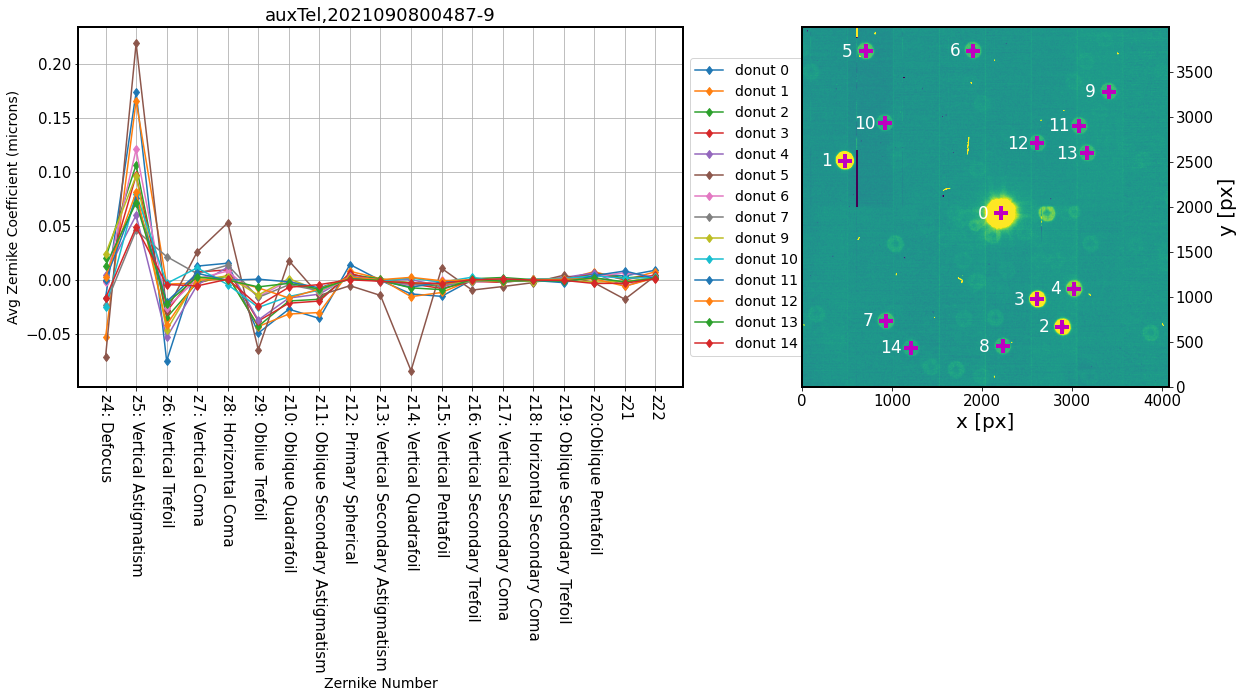

In [123]:
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

plot_results_and_image(exposure_extra.image.array, showZkByName=True)

Show the donut cutouts:

Text(0.5, 1.0, 'Intra')

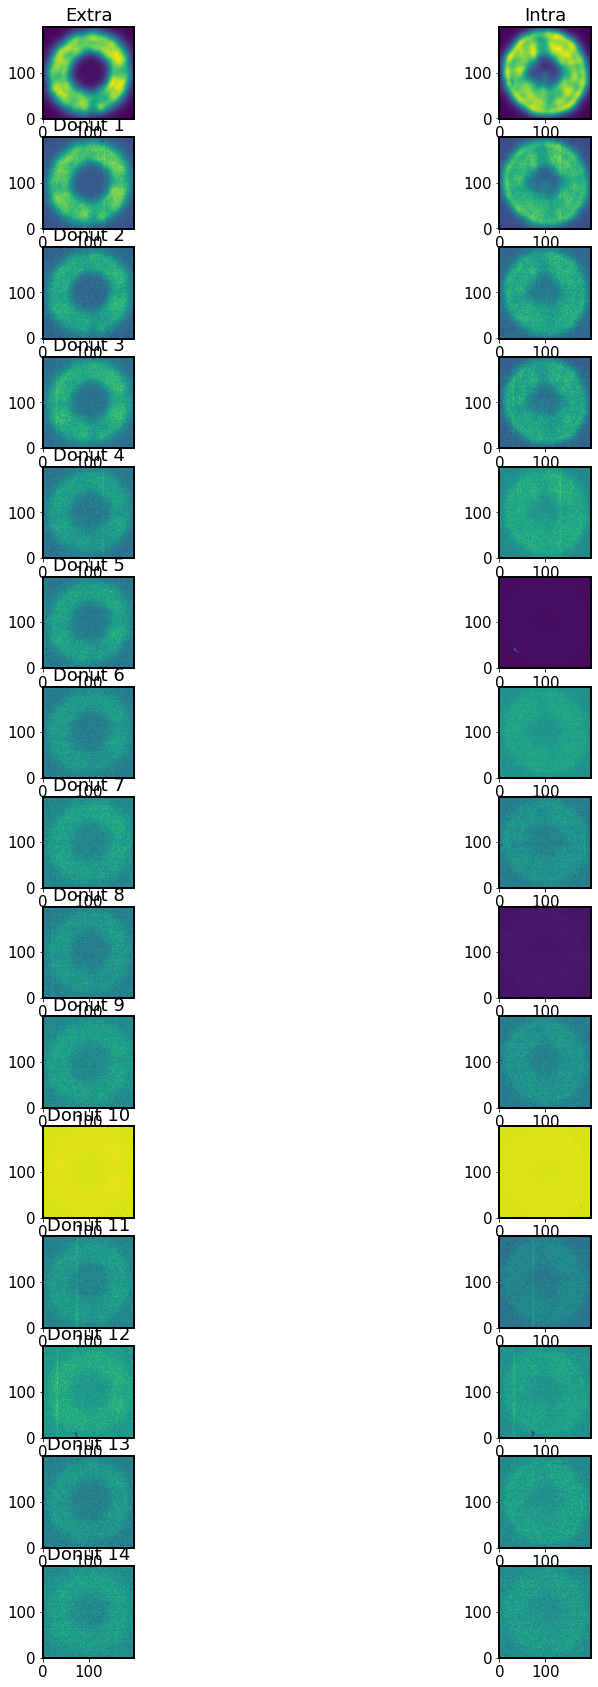

In [95]:
nrows = len(zernikeOutput.donutStampsExtra)
fig,ax = plt.subplots(nrows,2,figsize=(nrows, 2*nrows))

for i in range(nrows):
    donut = zernikeOutput.donutStampsExtra[i]
    ax[i,0].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    
    donut = zernikeOutput.donutStampsIntra[i]
    ax[i,1].imshow(donut.stamp_im.getArrays()[0], origin='lower')
    ax[i,0].set_title(f'Donut {i}')
ax[0,0].set_title('Extra')
ax[0,1].set_title('Intra')

Next: Incorporate this code to the `ts_wep` task